<a href="https://colab.research.google.com/github/liliarql/Text-mining-exercises/blob/main/Quispe_Lopez_Lilia_Ejercicio1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
def load_prepare_data(path):
  """
  Función para cargar y procesar datos para el ejercicio.
  """
  df = pd.read_csv(path,sep=",")
  map_classes = {
    "religion":1,
    "age":1,
    "ethnicity":1,
    "gender":1,
    "other_cyberbullying":1,
    "not_cyberbullying":0,
  }
  df["cyberbullying"] = df.cyberbullying_type.map(map_classes)
  return df[["tweet_text","cyberbullying"]].copy()

In [2]:
def load_prepare_data_2(path):
  """
  Función para cargar y procesar datos para el ejercicio.
  """
  df = pd.read_csv(path,sep=",")
  map_classes = {
    "religion":1,
    "age":2,
    "ethnicity":3,
    "gender":4,
    "other_cyberbullying":5,
    "not_cyberbullying":0,
  }
  df["cyberbullying"] = df.cyberbullying_type.map(map_classes)
  return df[["tweet_text","cyberbullying"]].copy()

# Ejercicio


En este ejercicio vamos a trabajar con un conjunto de datos procedente de medios sociales online.

Uno de los mayores problemas del internet hoy en día es la presencia de actitudes negativas hacia algunos colectivos en relación a su etnia, género, religión o ideología política. En este ejercicio trabajaremos con un conjunto de datos reales, etiquetados manualmente, procedentes de la plataforma [Kaggle](https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/data). Originalmente, a cada documento del dataset se le asignó una de las siguientes categorías:
- *religion*
- *age*
- *ethnicity*
- *gender*
- *other_cyberbullying*
- *not_cyberbullying*


El objetivo inicial del dataset era su uso para entrenar un modelo capaz de detectar el contenido de tipo odio presente en internet según el colectivo al que se atacaba. En este caso, para simplificar el ejercicio, se ha generado una función `load_prepare_data()` que cambia las categorías del dataset obteníendose al final 2 categorías con valor 1 o 0, indicando si el tweet tiene contenido de odio

Se trabaja con un conjunto de datos procedente de medios sociales online.

Uno de los mayores problemas del internet hoy en día es la presencia de actitudes negativas hacia algunos colectivos en relación a su etnia, género, religión o ideología política. En este ejercicio trabajaremos con un conjunto de datos reales, etiquetados manualmente, procedentes de la plataforma Kaggle. Originalmente, a cada documento del dataset se le asignó una de las siguientes categorías:

religion
age
ethnicity
gender
other_cyberbullying
not_cyberbullying
El objetivo inicial del dataset era su uso para entrenar un modelo capaz de detectar el contenido de tipo odio presente en internet según el colectivo al que se atacaba. En este caso, para simplificar el ejercicio, se ha generado una función load_prepare_data() que cambia las categorías del dataset obteníendose al final 2 categorías con valor 1 o 0, indicando si el tweet tiene contenido de odio

Para el ejercicio se debe entrenar diferentes modelos de clasificación que permitan clasificar correctamente los tweets. Para ello será necesario crear y utilizar funciones de preprocesado de datos, aplicar estrategias de vectorización de textos como TF-IDF o embeddings, y entrenar/evaluar modelos de clasificación.


## 0. Imports


In [3]:
!pip install gensim

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy

from wordcloud import WordCloud
from nltk.corpus import stopwords
from tqdm.autonotebook import tqdm
tqdm.pandas()
from transformers import pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader as api
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

<ipython-input-4-1372848437>:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 10.6 MB/s eta 0:00:00


In [6]:
import contractions

Import para tratamiento de los emojis

In [7]:
!wget https://www.clarin.si/repository/xmlui/handle/11356/1048/allzip
!unzip allzip
!apt-get install -y fonts-noto-color-emoji
!pip install emoji_extractor
from emoji_extractor.extract import Extractor

--2025-06-15 12:46:29--  https://www.clarin.si/repository/xmlui/handle/11356/1048/allzip
Resolving www.clarin.si (www.clarin.si)... 95.87.154.205
Connecting to www.clarin.si (www.clarin.si)|95.87.154.205|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: unspecified [application/zip]
Saving to: ‘allzip’

allzip                  [ <=>                ]  94.61K  --.-KB/s    in 0.09s   

2025-06-15 12:46:29 (1.06 MB/s) - ‘allzip’ saved [96878]

Archive:  allzip
  inflating: ESR_v1.0_format.txt     
  inflating: Emoji_Sentiment_Data_v1.0.csv  
  inflating: Emojitracker_20150604.csv  
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-noto-color-emoji
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.0 MB of archives.
After this operation, 11.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/mai

## 1. Obtención del corpus
Para la obtención de los datos teneis disponible la función `load_prepare_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe para que podais realizarlo.

In [8]:
path_data = "https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/cyberbullying_tweets.csv"
# Path de datos alternativos en caso de que el anterior no funcione (al estar alojado en github puede haber limitaciones
# en la descarga.
# path_data = "https://zenodo.org/records/10938455/files/cyberbullying_tweets.csv?download=1"
dataset = load_prepare_data(path_data)

In [9]:
dataset.head(4)

,tweet_text,cyberbullying
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0


## 2. Análisis exploratorio


En este apartado vamos a realizar una serie de análisis exploratorios sobre los datos antes de pasar a la parte de la normalización de los mismos. Este análisis nos va a permitir extraer información relevante del dataset, así como posibles incongruencias que tendremos que solucionar.

* **Número de documentos y columnas:**

Empezamos el análisis exploratorio con datos basicos, es decir saber el tamaño de nuestro dataset a traves del número de documentos y de columnas que lo compone.

In [10]:
dataset.count()

,0
tweet_text,47692
cyberbullying,47692


In [11]:
print("Tenemos un conjunto de {} documentos".format(len(dataset)))
print("El dataframe tiene {} columnas".format(dataset.shape[1]))

Tenemos un conjunto de 47692 documentos
El dataframe tiene 2 columnas


Nuestro dataset consta de 47.692 registros (o documentos), compuesto por un texto de un tweet y un boolean asociado que indica si el contenido del tweet es considerado como cyberbullying o no (valor de 1 o 0).

* **Número de documentos duplicados:**

Despues, comprobamos si existen tweets duplicados dentro del corpus, ya que con la funcion del "retweet" presente en la red social X, es algo que ocurre frecuentemente. Se eliminarán las filas con duplicados cuando se de el caso.

In [12]:
print("Existen {} documentos duplicados".format(np.sum(dataset.duplicated(subset=["tweet_text"]))))
# Quitaremos esos duplicados
dataset = dataset.drop_duplicates()
print("Despues de quitar duplicados tenemos un conjunto de {} documentos".format(dataset.shape[0]))

Existen 1675 documentos duplicados
Despues de quitar duplicados tenemos un conjunto de 47526 documentos


En este caso contamos de mas de 1600 retweets que eliminamos de la base, quedandonos con unos 47k documentos.

* **Número de documentos vacios:**

Si detectamos algún valor vacío (NA/Null), quitamos los registros correspondientes

In [13]:
print("Hay {} valores vacíos en las noticias y {} valores vacíos en las etiquetas en los datos".format(np.sum(dataset.isnull())[0],
                                                                                                        np.sum(dataset.isnull())[1]))

Hay 0 valores vacíos en las noticias y 0 valores vacíos en las etiquetas en los datos


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
<ipython-input-13-1747599386>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Hay {} valores vacíos en las noticias y {} valores vacíos en las etiquetas en los datos".format(np.sum(dataset.isnull())[0],
<ipython-input-13-1747599386>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n

En este caso, todo esta en orden, ya que no identificamos valores faltantes.

*   **Revisión del contenido de los tweets**

Vamos a revisar algunos tweets de cada una de las dos clases antes de realizar más analisis.

Tweets sin presencia de cyberbullying :

In [14]:
dataset[dataset.cyberbullying==0].sample(3).tweet_text.to_list()

['Those spatchcock are still alive! #MKR',
 "I'm trying to get work done, but this is a problem. http://t.co/OST7YSKhpO",
 'Never been so pissed off.']

Tweets con presencia de cyberbullying :

In [15]:
dataset[dataset.cyberbullying==1].sample(3).tweet_text.to_list()

['In regards to being harassed by GamerGate, i was just told: "Let your experience better you as a woman instead of seeking sympathy."',
 'A real terrorist hiding in fictional character, she and other terrorists run this agenda to demonise humanity and wanted bloodshed in the name of God, jihad, minority, being muslim',
 'No. The joke here is about prison rape. You know that "dont drop the soap" joke people made all the time in middle school? Yeah same thing. Many men fear prison bc of the high rape rates, and she\'s making a joke about it just simply "being gay"']

Esto nos permite entender un poco mejor que se entiende por tweet con y sin cyberbullying.

* **Distribución de documentos por cada clase:**

Aplicamos el `groupby()` para realizar el conteo del número de elementos de cada clase (cyberbullying / no cyberbullying).

En este caso nos encontramos dos categorías para los documentos (tweets):

- "Cyberbullying = 1": Tweets considerados como discriminantes y/o ofensivos ya sea para una communidad en concreto debido a su etnia, edad, religion, genero o bien otras caracteristicas.
- "Cyberbullying = 0": Tweets que se consideran respectuosos es decir sin comentarios ofensivos o pudiendo producir un malestar para el lector.

In [16]:
dataset.groupby(['cyberbullying']).count()

,tweet_text
cyberbullying,
0,7937
1,39589


Observamos a primera vista un fuerte desbalanceo entre las dos categorias de tweets. Procedemos a dibujar un histograma con las clases para facilitar la visualización:

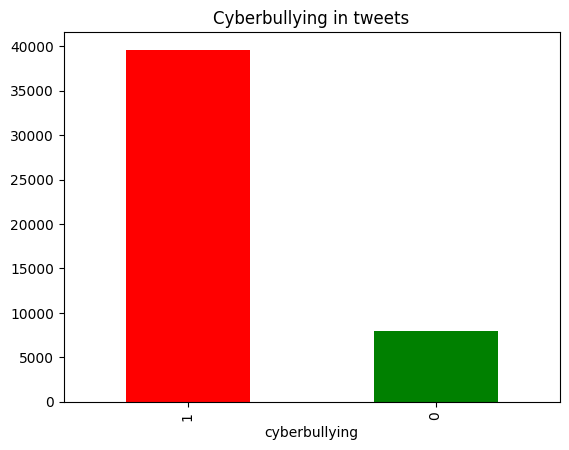

In [17]:
ax, fig = plt.subplots()
etiquetas = dataset.cyberbullying.value_counts()
etiquetas.plot(kind= 'bar', color= ["red", "green"])
plt.title('Cyberbullying in tweets')
plt.show()

Este desequilibrio entre los tweets de odio y los tweets sin cyberbullying provienen de la estructura del corpus a disposicion. Como bien se indica en la descripcion del Kaggle, "*The data has been balanced in order to contain ~8000 of each class.*".

Es decir, tenemos aprox. 8000 elementos de cada tipo de cyberbullying (edad, religion, etc...) y 8000 sin cyberbullying. Realizamos una carga de un segundo dataset rapidamente para comprobarlo. Creamos un **dataset_2** con el cual hemos clasificado el cyberbulling ya no como un boolean sino como una variable multiclase usando la funcion transformada `load_prepare_data_2`.

In [18]:
dataset_2 = load_prepare_data_2(path_data)
dataset_2 = dataset_2.drop_duplicates()
dataset_2.groupby(['cyberbullying']).count()

,tweet_text
cyberbullying,
0,7937
1,7997
2,7992
3,7959
4,7948
5,7823


De nuevo, realizamos un grafico para que sea mas visual

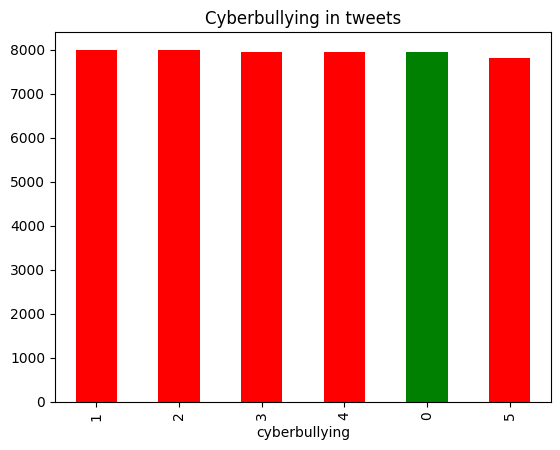

In [19]:
ax, fig = plt.subplots()
etiquetas = dataset_2.cyberbullying.value_counts()
etiquetas.plot(kind= 'bar', color= ["red","red","red","red","green","red"])
plt.title('Cyberbullying in tweets')
plt.show()

Esta vez si que observamos datos balanceados. Sin embargo, dado que en este ejercicio propuesto queremos trabajar con una variable binaria (es cybebullying o no es cyberbullying), vamos a tener que modificar nuestra base aplicando un metodo de rebalanceo para compensar este efecto. Lo aplicaremos en la parte 5 despues de haber realizado la vectorizacion.

* **Distribución de la longitud de los tweets:**

Seguimos el análisis exploratorio con un cálculo tipico para este tipo de dataset: calculamos la longitud de cada uno de los textos de los documentos para posteriormente dibujar su histograma y ver si observamos diferencias relevantes entre las categorías del dataset y la longitud de los tweets:

In [20]:
dataset["char_len"] = dataset["tweet_text"].apply(lambda x: len(x))

<Figure size 1400x1200 with 0 Axes>

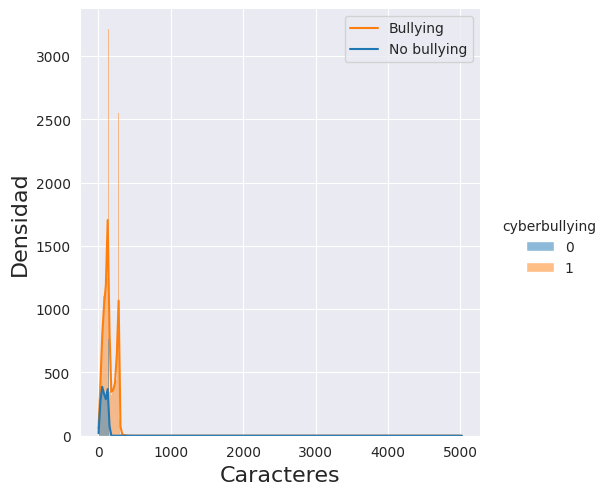

In [21]:
# Importamos las librerías matplotlib y seaborn:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")

sns.displot(data=dataset, x="char_len", hue="cyberbullying", kde=True, legend=True)
plt.legend(["Bullying", "No bullying"])
# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()


El resultado es algo muy difficil de leer, probablemente hay algun tweet atipico con muchos caracteres.

In [22]:
max(dataset["char_len"])

5018

Efectivamente, el tweet con mas caracteres tiene 5018. Realizamos nuevamente el grafico pero vamos a limitar el eje de los caracteres a 300, para tener mas visibilidad.

<Figure size 1400x1200 with 0 Axes>

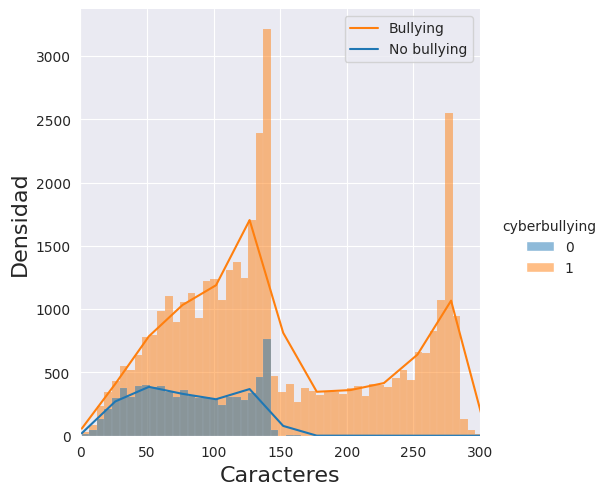

In [23]:
# Importamos las librerías matplotlib y seaborn:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")

sns.displot(data=dataset, x="char_len", hue="cyberbullying", kde=True, legend=True)
plt.legend(["Bullying", "No bullying"])
# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)
plt.xlim((0,300))

# Finalmente mostramos el gráfico:
plt.show()

Observamos algo bastante claro aqui. Si bien de forma general vemos que siempre existe mas tweets con los maximos de caracteres posibles, la curva es mucho mas plana para los tweets sin cyberbullying, es decir no hay muchos mas tweets extensos que tweets cortos en caso de publicar un comentario que no contiene cyberbullying. Sin embargo, en el caso contrario, suele haber un proporcion mucho mas importante de tweets largos. Eso significa que los autores responsables de cyberbullying suelen redactar tweets mas largo, utilizando muy a menudo la totalidad de los caracteres disponibles.

Cabe agregar un dato relevante para analizar ese grafico. Observamos dos puntas en 140 y 280, que se explica simplemente por la fecha de publicacion del tweet. Efectivamente, el numero de caracteres maximo que se puede usar ha ido cambiando en el tiempo:

* desde su creacion en 2006 hasta 2017, **140** caracteres
* desde 2017 hasta 2023, **280** caracteres
* desde 2023, entre **280** y **4000** caracteres dependiendo del tipo de cuenta




Tambien acabamos observando que casi no hay tweets sin cyberbullying que superan los 140 caracteres, lo que podria dejar pensar que ha sido mas difficil encontrar tweets respectuosos con una fecha de publicacion mas reciente, y por ende traduciria un aumento en el tiempo del discurso de odio en la red social. Sin embargo, lo mas probable es que debido a la metodologia de coleccion de los datos, no se haya recogido tweet sin cyberbullying en fechas mas recientes. Esto puede resultar problematico si usamos la variable de numero de caracteres dentro del modelo de clasificacion. La recomendacion seria no usarla. Podemos tambien crear un dataset considerando solamente los tweets de 140 caracteres y menos, para comparar los modelos y ver si la longitud es una variable que podria tener una relevancia importante en la prediccion.

In [24]:
dataset_140 =dataset[dataset["char_len"]<=140]

In [25]:
dataset_140.head(4)

,tweet_text,cyberbullying,char_len
0,"In other words #katandandre, your food was cra...",0,61
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,115
2,@XochitlSuckkks a classy whore? Or more red ve...,0,60
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0,103


<Figure size 1400x1200 with 0 Axes>

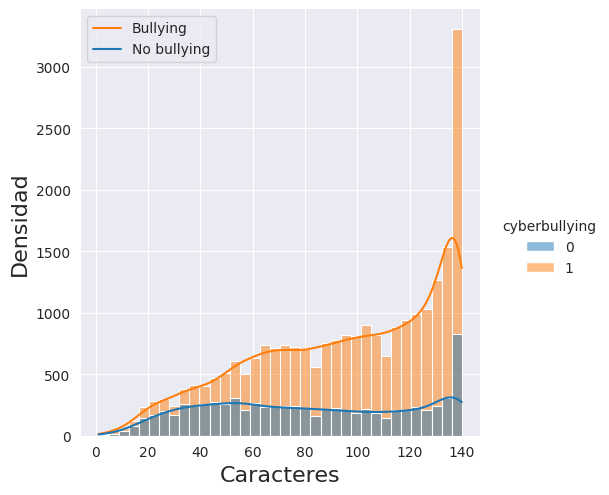

In [26]:
fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")
sns.displot(data=dataset_140, x="char_len", hue="cyberbullying", kde=True, legend=True)
plt.legend(["Bullying", "No bullying"])

plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

plt.show()

Obtenemos un grafico mas claro, con una tendencia igual a la que comentamos anteriormente. Veamos como esta distribuida nuestra variable a predecir despues de este cambio:

In [27]:
dataset_140.groupby(['cyberbullying']).count()

,tweet_text,char_len
cyberbullying,,
0,7848,7848
1,24865,24865


Sigue desbalanceada (aunque menos). Se tratara a la vez que el otro dataset. Volveremos a crear ese dataset una vez realizadas todas las normalizaciones y otros analisis adicionales.

 * **Visualizacion Wordcloud (analisis de contenido)**

Vamos a generar graficos Wordcloud que permite tener una visualizacion de los terminos que mas aparecen en los tweets.

Para generar los gráficos necesitamos obtener una variable de tipo string que contenga todos los textos con los que queremos llevar a cabo la visualización. En este caso obtendremos separadamente los tweets asociados a la categoría 0 y a la categoría 1. Usaremos la biblioteca **wordcloud**

In [28]:
from wordcloud import WordCloud
txt_cat0 = ",".join(dataset[dataset.cyberbullying==0].tweet_text.to_list())
txt_cat1 = ",".join(dataset[dataset.cyberbullying==1].tweet_text.to_list())

Creamos ahora el objeto WordCloud con la configuración que nos permita obtener las visualizaciones, e ignoremos los stopwords.

In [29]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [30]:
from nltk.corpus import stopwords
en_stopwords = stopwords.words('english')

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0,
                      contour_color='steelblue', stopwords=en_stopwords,
                      normalize_plurals = True)

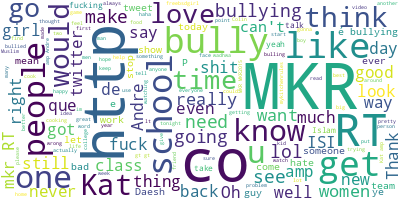

In [31]:
# Genera el wordcloud cyberbullying==0
wordcloud.generate(txt_cat0)
# Visualizalo en una imagen
wordcloud.to_image()

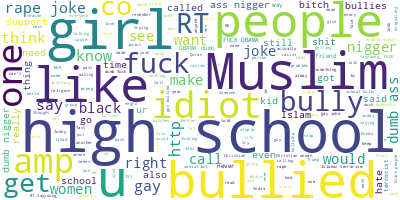

In [32]:
# Genera el wordcloud cyberbullying==1
wordcloud.generate(txt_cat1)
# Visualizalo en una imagen
wordcloud.to_image()

Los resultados nos dan algunas indicaciones sobre la tendencia de una categoria y de la otra:

* En el wordcloud de la categoría 0 observamos dentro de los terminos mas presentes las palabras *http* y *co* lo que traduce una fuerte presencia de URLs, así como de la palabra *RT*, acronimo para decir "retweet". Algunos terminos tambien resaltan como *bully*, *school*, *like* o *people*. Son términos en general bastante neutros. El termino que mas sale es *MKR*, cuyo significado no se logró decodificar, sin embargo por lo investigado se podria tratar del acronimo de una popular emision de television en Australia.

* En el wordcloud asociado a la categoría 1 se observa una menor frecuencia de los términos *http*, *co* y *RT* (es decir que habrá menos URLs y menos retweet en el contenido). Aparecen adjetivos que expresan potencial discriminacion o objeto de burla como *muslim*, *girl* o *high school* e insultos como *idiot* y *fuck*.

Se observan algunos terminos similares dentro de los más presentes en ambos grupos (*people*, *bully*,*one*, *school*), sin embargo también varias diferencias.

* **Analisis de emoji**

Ahora vamos a realizar un paso importante que es el tratamiento de los emojis. Empezamos por definir la funcion permitiendo de extraer los emijos del texto del tweet en una columna aparte, para facilitar su analisis y tratamiento.

In [33]:
def extract_emojis(text):
  extract = Extractor()
  emojis = extract.count_emoji(text, check_first=False)
  emojis_list = [key for key, _ in emojis.most_common()]
  return emojis_list

In [34]:
dataset["emojis"] = dataset["tweet_text"].apply(lambda x: extract_emojis(x))

Empezamos por analizar cuantos tweets contienen emojis

In [35]:
filas_con_icono = dataset[dataset['emojis'].apply(lambda x: len(x) >= 1)]
filas_sin_icono = dataset[dataset['emojis'].apply(lambda x: len(x) ==0)]

# Imprimir el resultado
print("Número de filas con al menos un icono:", len(filas_con_icono))
print("Número de filas sin iconos:", len(filas_sin_icono))

Número de filas con al menos un icono: 435
Número de filas sin iconos: 47091


Tenemos aproximadamente 1% de los tweets que tiene al menos un emoji. Si bien es (sorprendentemente) poco, se puede considerar eventualmente relevante para el modelo de clasificación, por lo cual vamos a completar el análisis de los emojis en nuestro dataset.

In [36]:
#recargamos los registros que contienen emojis y los separamos en funcion de si el tweet contiene bullying o no:
filas_emoji_cyberbullying = filas_con_icono[filas_con_icono['cyberbullying'] == 1].emojis.to_list()
filas_emoji_no_cyberbullying = filas_con_icono[filas_con_icono['cyberbullying'] == 0].emojis.to_list()

filas_emoji_cyberbullying = [item for sublist in filas_emoji_cyberbullying for item in sublist]
filas_emoji_no_cyberbullying = [item for sublist in filas_emoji_no_cyberbullying for item in sublist]

Ahora visualizemos los emojis mas representados para cada categoria de tweet:

<ipython-input-37-461105676>:26: UserWarning: Glyph 128548 (\N{FACE WITH LOOK OF TRIUMPH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-37-461105676>:26: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-37-461105676>:26: UserWarning: Glyph 128076 (\N{OK HAND SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128548 (\N{FACE WITH LOOK OF TRIUMPH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128076 (\N{OK HAND SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io

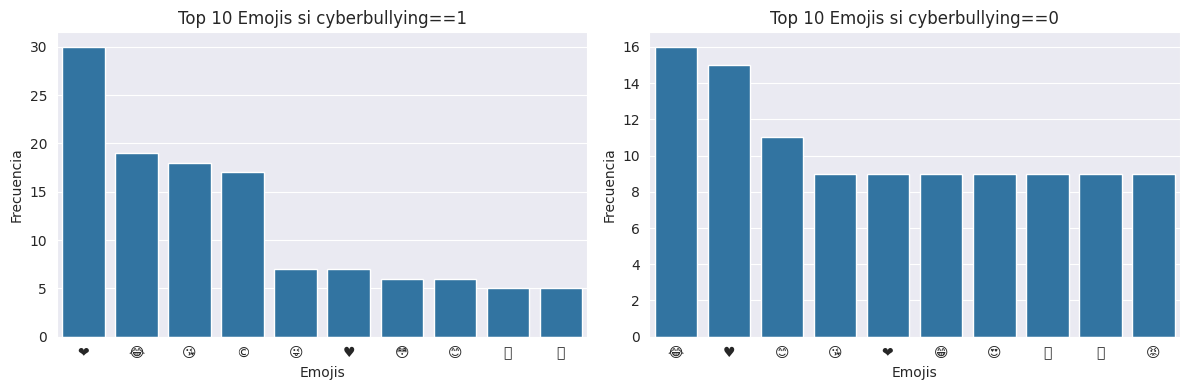

In [37]:
from collections import Counter
from matplotlib import font_manager

freq_emoji_cyberbullying = Counter(filas_emoji_cyberbullying)
freq_emoji_no_cyberbullying = Counter(filas_emoji_no_cyberbullying)

emojis1, frecuencias_elementos1 = zip(*sorted(freq_emoji_cyberbullying.items(), key=lambda x: x[1], reverse=True)[:10])
emojis0, frecuencias_elementos0 = zip(*sorted(freq_emoji_no_cyberbullying.items(), key=lambda x: x[1], reverse=True)[:10])


fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Barplot 1
sns.barplot(x=emojis1, y=frecuencias_elementos1, ax=axes[0])
axes[0].set_xlabel('Emojis')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Top 10 Emojis si cyberbullying==1')

# Barplot 2
sns.barplot(x=emojis0, y=frecuencias_elementos0, ax=axes[1])
axes[1].set_xlabel('Emojis')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Top 10 Emojis si cyberbullying==0')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la imagen
plt.show()

No se observa una gran diferencia de emojis usados entre ambas categorias. En los dos top 10 aparecen corazones, el emoji de risa, del beso...
Visto la baja frecuencia de aparicion de los emojis y la similaridad de los mismos en ambas categorias de cyberbullying, podemos tener dudas sobre su aportacion al modelo de clasificacion. Es probable que acabe teniendo un impacto limitado.

Pasamos ahora a la parte de preprocesado y normalizacion del dataset.

## 3. Preprocesado y Normalización

En esta parte vamos a realizar el preprocesado normalizando los datos.

Principalmente realizaremos lo siguiente:

* Eliminar espacios extra entre términos (palabras vacias)
* Transformar a minúsculas
* Reemplazar contracciones del inglés por su versión extensa
* Quitar signos de punctuación
* Tokenizar y normalizar URLs y menciones de twitter y números por tokens comunes
* Eliminar los Stopwords
* Lematizar

* **Funciones para eliminar espacios extra entre términos, poner todo en minuscula y reemplazar las contracciones en ingles por su version completa**

In [38]:
!pip install contractions

In [39]:
# Eliminar espacios
def eliminar_espacios(text):
    return  " ".join(text.split())

# Transformar en minusculas
def texto_to_lower(text):
  return text.lower()

# Reemplazar las contracciones y jerga en ingles
# Para este punto usamos la libreria contraction
import contractions
def replace_contraction(text):
    return contractions.fix(text, slang=True)

Aplicamos estas funciones a nuestros dataset y asi permitimos reducir la dimensionalidad sin perdida de informacion.

In [40]:
dataset["normalizado"] = dataset["tweet_text"].progress_apply(lambda x: eliminar_espacios(x))
dataset["normalizado"] = dataset["normalizado"].progress_apply(lambda x: texto_to_lower(x))
dataset["normalizado"] = dataset["normalizado"].progress_apply(lambda x: replace_contraction(x))

  0%|          | 0/47526 [00:00<?, ?it/s]

  0%|          | 0/47526 [00:00<?, ?it/s]

  0%|          | 0/47526 [00:00<?, ?it/s]

* **Tokenizacion**

En la parte de tokenizacion, vamos a aplicar las mismas transformaciones que las vistas en clase, dado su relevencia al tratarse de un problema bastante parecido (analisis de tweets con clase binaria). Empezaremos entonces por introducir el tokenizer especifico para documentos de tweeter permitiendo de realizar tokens mucho mas relevantes. Reemplazarlas caracteristicas de url, menciones y numeros por las palabras URL, MENTION y NUM permiten, al igual que poner el texto en minuscula utilizando To_Lower, de reducir la dimensionalidad y ganar en eficacia.

In [41]:
# Tokenizador
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()

def normalizar_tokens(documento):
    # Dividir el documento en palabras
    palabras =  tweet_tokenizer.tokenize(documento)

    # Reemplazar URLs, menciones de Twitter y números por los tokens correspondientes
    for i in range(len(palabras)):
        if palabras[i].startswith("http://") or palabras[i].startswith("https://") or palabras[i].startswith("www."):
            palabras[i] = "url"
        elif palabras[i].startswith("@"):
            palabras[i] = "mention"
        elif palabras[i].isdigit():
            palabras[i] = "num"

    # Unir las palabras de nuevo en un documento modificado
    documento_modificado = ' '.join(palabras)

    return documento_modificado

In [42]:
dataset["normalizado"] = dataset["normalizado"].progress_apply(lambda x: normalizar_tokens(x))

  0%|          | 0/47526 [00:00<?, ?it/s]

* **Lematizar**

In [43]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lematizar(texto):
    # Procesar el texto con el objeto nlp
    documento = nlp(texto)
    # Lematizar el texto
    lematizado = [token.lemma_ for token in documento]

    return lematizado

* **Quitar Stopwords y signos de puntuación**

In [44]:
def eliminacion_sw(texto_lema):
    # Eliminar signos de puntuación y stopwords
    tokens_limpios = [token for token in texto_lema if token.isalpha() and token.lower() not in en_stopwords]

    # Unir los tokens filtrados en un nuevo texto
    texto_procesado = ' '.join(tokens_limpios)

    return texto_procesado

Aplicamos nuestras funciones (**cuidado!** demora aprox. 4-6 minutos en ejecutarse)

In [45]:
dataset["lematizado"] = dataset["normalizado"].progress_apply(lambda x: lematizar(x))
dataset["preprocesado"] = dataset["lematizado"].progress_apply(lambda x: eliminacion_sw(x))

  0%|          | 0/47526 [00:00<?, ?it/s]

  0%|          | 0/47526 [00:00<?, ?it/s]

Observamos algunos tweets

In [46]:
dataset[dataset.cyberbullying==0].sample(5).preprocesado.to_list()

['mention even attempt major attack weak succeed every attack thin even',
 'mention mention mention thank get offer croix united',
 'mention yh grow fail real world end get bully',
 'mention mention mention see crap lie example never num million american imdians',
 'gordon ramsay mkr']

In [47]:
dataset[dataset.cyberbullying==1].sample(5).preprocesado.to_list()

['wow incredibly lame go fix anything people alive today subject thing happen long time ago past far deserve damned penny simply black',
 'school shooting fight back murder even go suppose bully go innocent people literal clown',
 'horrified see girl go grade school high school foryoupage tik tok bitch bully throughout school',
 'fight woman suggest even crazy troll like still live world live black woman call another african american nigger ashamed fact disgusting',
 'also mention stupid thirsty ass gay think rape joke funny']

Finalmente observamos algunas estadisticas sobre los números de menciones, de URL y de digitos presentes en los tweet:

In [48]:
def token_appearance(documento, token = "MENTION"):
  return len([x for x in documento.split() if x == token])

In [49]:
dataset["num_mention"] = dataset["preprocesado"].progress_apply(lambda x: token_appearance(x, token="mention"))
dataset["num_URLS"] = dataset["preprocesado"].progress_apply(lambda x: token_appearance(x, token="url"))
dataset["num_NUM"] = dataset["preprocesado"].progress_apply(lambda x: token_appearance(x, token="num"))

  0%|          | 0/47526 [00:00<?, ?it/s]

  0%|          | 0/47526 [00:00<?, ?it/s]

  0%|          | 0/47526 [00:00<?, ?it/s]

In [50]:
print("Hay {} menciones, {} URLs y {} numeros en los {} tweets de la base de datos.".format(np.sum(dataset["num_mention"]),
                                                                                         np.sum(dataset["num_URLS"]),
                                                                                         np.sum(dataset["num_NUM"]),
                                                                                         dataset.shape[0]))

Hay 27148 menciones, 4528 URLs y 5930 numeros en los 47526 tweets de la base de datos.


* **Caracteristicas de sentimiento**

Como se ha mostrado en clase, resulta interesante calcular algunas metricas en base a los emojis para crear características adicionales que agregar en el modelo. Aunque hemos comentado que probablemente el impacto de los emojis sea limitado en nuestro caso, vamos a llevar a cabo este análisis.

In [51]:
def load_emoji_sentiment(path):
  # Cargamos el csv de emoji_sentiment
  emoji_sent_df = pd.read_csv(path,sep=",")
  # Calculamos los scores dividiendo el número de emojis negativos y entre el total
  emoji_sent_df["Negative"] = emoji_sent_df["Negative"]/emoji_sent_df["Occurrences"]
  emoji_sent_df["Neutral"] = emoji_sent_df["Neutral"]/emoji_sent_df["Occurrences"]
  emoji_sent_df["Positive"] = emoji_sent_df["Positive"]/emoji_sent_df["Occurrences"]
  # Transformamos a dict
  emoji_sent_df = emoji_sent_df.set_index('Emoji')
  emoji_dict = emoji_sent_df.to_dict(orient="index")
  return emoji_dict

In [52]:
emoji_sent_dict = load_emoji_sentiment("Emoji_Sentiment_Data_v1.0.csv")

In [53]:
def get_emoji_sentiment(lista, option = "positive"):
  output = 0
  for emoji in lista:
    try:
      if option == "positive":
        output = output + emoji_sent_dict[emoji]["Positive"]
      elif option =="negative":
        output = output + emoji_sent_dict[emoji]["Negative"]
      elif option =="neutral":
        output = output + emoji_sent_dict[emoji]["Neutral"]
    except Exception as e:
      continue

  if len(lista)>=1:
    longitud = len(lista)
  else:
    longitud =1
  return output/ longitud

In [54]:
dataset["sent_emoji_pos"] = dataset["emojis"].apply(lambda x: get_emoji_sentiment(x, "positive"))
dataset["sent_emoji_neu"] = dataset["emojis"].apply(lambda x: get_emoji_sentiment(x, "neutral"))
dataset["sent_emoji_neg"] = dataset["emojis"].apply(lambda x: get_emoji_sentiment(x, "negative"))

In [55]:
from textblob import TextBlob
dataset["tweet_sentiment_polarity"] = dataset["preprocesado"].apply(lambda x: TextBlob(x).sentiment.polarity)
dataset["tweet_sentiment_subjectivity"] = dataset["preprocesado"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

Pasamos ahora a la parte de vectorización...

## 4. Vectorización

Ahora pasamos a realizar la vectorizacion. Para ello vamos a aplicar los distintos métodos de vectorizacion vistos en clase: la vectorizacion TF-IDF y luego la vectorizacion Word Embeddings. Acabaremos también por agregar caracteristicas adicionales

* **Vectorizacion TF-IDF**

Para esta vectorizacion, vamos a considerar los siguientes aspectos:

- Vamos a considerar unigramas, bigramas y trigramas
- Vamos a parametrizar el vectorizador de tal forma a que no se consideren los elementos que salgan en menos del 0.1% de los documentos.

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizador = TfidfVectorizer(lowercase = False, stop_words =None,
                               min_df=0.001, ngram_range = (1,3))

vector_data_tfidf = vectorizador.fit_transform(dataset["preprocesado"])

In [57]:
vector_data_tfidf

<47526x2093 sparse matrix of type '<class 'numpy.float64'>'
	with 549495 stored elements in Compressed Sparse Row format>

Como resultado tenemos un output de vectores de tamaño 2084, lo que es aceptable visto el tamaño de la base de datos.

* *Incorporación de características adicionales*






Vamos a incorporar a la vectorización los 3 conteos (mencion, url, numeros) que hemos parametrizado en la parte anterior. También se agregará la variable "char_len" creado en la primera parte que representa la longitud del tweet, y caracteristicas proveniente del analisis de emojis hecha anteriormente.

In [58]:
extra_features_tfidf = dataset[['num_mention','num_URLS','num_NUM',
                          'tweet_sentiment_subjectivity','tweet_sentiment_polarity',
                          'sent_emoji_pos','sent_emoji_neg','sent_emoji_neu']]

Como ya lo hemos visto en clase, usaremos la libreria scipy para generar una matriz unificando nuestras variables

In [59]:
import scipy as sp
y = dataset["cyberbullying"].values.astype(np.float32)
X_tfidf = sp.sparse.hstack((vector_data_tfidf,extra_features_tfidf.values),format='csr')

In [60]:
X_tfidf

<47526x2101 sparse matrix of type '<class 'numpy.float64'>'
	with 652360 stored elements in Compressed Sparse Row format>

Comprobamos con el vector de tamaño 2092 que se agregaron correctamente los elementos adicionales.

* **Vectorizacion Word Embeddings**

Para realizar la vectorizacion Word Embeddings vamos a utilizar la libreria gensim y cargamos el "glove-twitter-25"

In [61]:
import gensim.downloader as api
glove_emb = api.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [62]:
def get_average_vector(sentence):
  tokens = normalizar_tokens(sentence)
  lista = list()
  for i in tokens:
    try:
      lista.append(glove_emb.get_vector(i) )
    except:
      continue

  try:
    resultado = np.mean(lista, axis=0)
  except:
    resultado = np.zeros(25)
  return resultado

In [63]:
dataset["embeddings"] = dataset["preprocesado"].progress_apply(lambda x: get_average_vector(x))

  0%|          | 0/47526 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [64]:
vector_data_emb = pd.concat([dataset.embeddings.apply(pd.Series),
                dataset[['num_mention','num_URLS','num_NUM',
                          'tweet_sentiment_subjectivity','tweet_sentiment_polarity',
                          'sent_emoji_pos','sent_emoji_neg','sent_emoji_neu']]], axis=1)

In [65]:
vector_data_emb.shape

(47526, 33)

In [66]:
vector_data_emb = vector_data_emb.fillna(0)

In [67]:
import scipy as sp
y = dataset["cyberbullying"].values.astype(np.float32)
X_emb = sp.sparse.hstack((vector_data_tfidf,vector_data_emb.values),format='csr')

In [68]:
X_emb

<47526x2126 sparse matrix of type '<class 'numpy.float64'>'
	with 1839910 stored elements in Compressed Sparse Row format>

Pasamos ahora a la última parte, de entrenamiento, validacion y evaluacion de modelos.

## 5. Entrenamiento y evaluación de modelos


Vamos a constituir el dataset de entrenamiento y el dataset de validación. La variable **y** que hemos definido previamente es nuestra variable respuesta, es decir el campo "cyberbullying". Las otras variables fueron definidas dentro de la matriz X.
Creamos varios datasets, con las dos vectorizaciones que hemos llevado a cabo en la parte anterior, así como con la base dataset y la base dataset_140 que contiene solamente los tweets con menos de 140 caracteres. Dejamos en este notebook el dataset que mejores resultados ha dado.

In [69]:
#volvemos a crear dataset con solo tweets de 140 caracteres
dataset_140c =dataset[dataset["char_len"]<=140]

#vectorizacion TF-IDF
vector_data_tfidf_140 = vectorizador.fit_transform(dataset_140c["preprocesado"])
extra_features_tfidf_140 = dataset_140c[['num_mention','num_URLS','num_NUM',
                          'tweet_sentiment_subjectivity','tweet_sentiment_polarity',
                          'sent_emoji_pos','sent_emoji_neg','sent_emoji_neu']]
y_140 = dataset_140c["cyberbullying"].values.astype(np.float32)
X_tfidf_140 = sp.sparse.hstack((vector_data_tfidf_140,extra_features_tfidf_140.values),format='csr')

#vectorizacion embeddings
vector_data_emb_140 = pd.concat([dataset_140c.embeddings.apply(pd.Series),
                dataset_140c[['num_mention','num_URLS','num_NUM',
                          'tweet_sentiment_subjectivity','tweet_sentiment_polarity',
                          'sent_emoji_pos','sent_emoji_neg','sent_emoji_neu']]], axis=1)
X_emb_140 = sp.sparse.hstack((vector_data_tfidf_140,vector_data_emb_140.values),format='csr')

Ahora vamos realizando los datasets de entrenamiento y validación

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, random_state=0)
X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(X_emb, y, random_state=0)
X_train_140, X_test_140, y_train_140, y_test_140 = train_test_split(X_tfidf_140, y_140, random_state=0)
X_train_emb_140, X_test_emb_140, y_train_emb_140, y_test_emb_140 = train_test_split(X_emb_140, y_140, random_state=0)
print(X_train.shape)
print(X_test.shape)

(35644, 2101)
(11882, 2101)


Antes de cargar los modelos, empezamos por definir la función vista en clase, la cuál nos permite comparar distintos modelos y muestra la evaluación de cada uno para que podamos apreciar cuál es el mas adecuado.

In [71]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings

# Definimos la función encargada de evaluar los modelos:
def model_evaluation(models, score, X, y):
      results = []
      names = []
      #Para cada modelo
      for name, model in models:
          warnings.filterwarnings('ignore')
          # Generamos un StratifiedKFold
          KF = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 98)

          # hacemos croos_val
          cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)

          # Guardamos los resultados:
          results.append(cv_results)
          names.append(name)

          # Mostramos los resultados numéricamente:
          print('Metric: {} , KFold '.format(str(score)))
          print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

      return results, names

Ahora pasamos a cargar los modelos que queremos probar para la evaluación. En este caso vamos a probar 3 modelos : una regresion logistica, un modelo de Gauss y un arbol de decision.

In [72]:
# Cargamos los modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Definimos los modelos y generamos una lista con cada uno de ellos:
models = [
         ("Logistic",LogisticRegression(random_state=30)),
         ("GaussianNB",GaussianNB()),
         ("DecisionTree",DecisionTreeClassifier())
]

evaluation_score = "accuracy"

model_evaluation(models,  evaluation_score, X_train_emb.toarray(), y_train_emb)

Metric: accuracy , KFold 
Logistic: 0.866962 (0.003461) 
Metric: accuracy , KFold 
GaussianNB: 0.662692 (0.002236) 
Metric: accuracy , KFold 
DecisionTree: 0.807906 (0.003231) 


([array([0.87137046, 0.86295413, 0.86856502, 0.86281386, 0.86910774]),
  array([0.66503016, 0.66545097, 0.66012063, 0.66040118, 0.66245791]),
  array([0.80403984, 0.808248  , 0.80880909, 0.80516201, 0.8132716 ])],
 ['Logistic', 'GaussianNB', 'DecisionTree'])

Aqui observamos un accuracy del 86,78% para el modelo de regresion logística con la vectorización embeddings, mientras que es de 65,35% para el modelo naive Bayes y 80,84% para el arbol de decision. Siendo la desviación tipica bastante baja en todos los casos, retenemos el modelo de regresión logística para seguir ajustando sus hiperparametros y asi intentar mejorar su rendimiento.

A continuación se muestran los resultados obtenidos con los otros datasets

*Resultados con X_train*

        Metric: accuracy , KFold
        Logistic: 0.865644 (0.002681)
        Metric: accuracy , KFold
        GaussianNB: 0.653546 (0.002199)
        Metric: accuracy , KFold
        DecisionTree: 0.825160 (0.004000)
        ([array([0.86926638, 0.86379576, 0.86547903, 0.86183195, 0.86784512]),
          array([0.65507084, 0.65128349, 0.6542292 , 0.6507224 , 0.65642536]),
          array([0.82129331, 0.82045168, 0.82648338, 0.82606256, 0.83150954])],
        ['Logistic', 'GaussianNB', 'DecisionTree'])

*Resultados con X_train_emb*

      Metric: accuracy , KFold
      Logistic: 0.867860 (0.003355)
      Metric: accuracy , KFold
      GaussianNB: 0.653574 (0.002097)
      Metric: accuracy , KFold
      DecisionTree: 0.806531 (0.001896)
      ([array([0.87193155, 0.86547903, 0.86758311, 0.8630944 , 0.87121212]),
        array([0.65507084, 0.65142376, 0.6542292 , 0.65086267, 0.65628507]),
        array([0.80586337, 0.81007154, 0.80656474, 0.80446065, 0.80569585])],
      ['Logistic', 'GaussianNB', 'DecisionTree'])

*Resultados con X_train_140*

      Metric: accuracy , KFold
      Logistic: 0.809693 (0.003725)
      Metric: accuracy , KFold
      GaussianNB: 0.611071 (0.005167)
      Metric: accuracy , KFold
      DecisionTree: 0.759762 (0.005653)
      ([array([0.80374975, 0.81006725, 0.81353169, 0.81353169, 0.80758255]),
        array([0.61218667, 0.60546159, 0.60912981, 0.60811086, 0.62046474]),
        array([0.76074995, 0.76238027, 0.76543713, 0.7489301 , 0.76131268])],
      ['Logistic', 'GaussianNB', 'DecisionTree'])

Vamos a utilizar la funcionalidad de GridSearch para ajustar los hiperparametros a su nivel óptimo y sacar el mejor rendimiento posible del modelo.

In [73]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

In [74]:
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

In [75]:
grid_result = grid_search.fit(X_train_emb, y_train_emb)
# summarize results
print("Mejor accuracy: %f usando los parámetros %s" % (grid_result.best_score_, grid_result.best_params_))

Mejor accuracy: 0.867748 usando los parámetros {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}


Con el ajuste de los hiperparametros, la accuracy no mejora y se queda igual. Usemos los parametros dados por el GridShearch para ejecutar el modelo.

In [76]:
from sklearn.model_selection import (KFold, cross_val_score,cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

model=LogisticRegression(C=1, penalty="l2", solver = "liblinear")
model.fit(X_train_emb,y_train_emb)

LogisticRegression(C=1, solver='liblinear')

Predecimos con el set de test, y creamos una matriz de confusión y un "classification report".

In [77]:
y_pred = model.predict(X_test_emb)

from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test_emb,y_pred))
print(classification_report(y_test_emb,y_pred))

[[ 756 1223]
 [ 323 9580]]
              precision    recall  f1-score   support

         0.0       0.70      0.38      0.49      1979
         1.0       0.89      0.97      0.93      9903

    accuracy                           0.87     11882
   macro avg       0.79      0.67      0.71     11882
weighted avg       0.86      0.87      0.85     11882



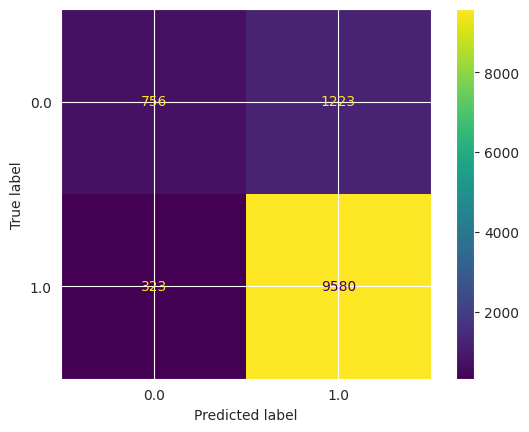

In [78]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, X_test_emb, y_test_emb, normalize = None)

Observamos un resultado gobal bueno, pero cuando vemos mas a detalle los resultados, el f1-score es muy bajo para el valor a predecir 0, y el recall no es bueno en absoluto. Un 0.97 para el valor 1 vs un 0.39 para el valor 0 es muy probablemente debido a que el modelo tiene una variable respuesta desequilibrada y que al tener practicamente solo el valor 1 en el dataset, el modelo tiende a predecir siempre por el 1, dando un mal rendimiento en este segmento. El efecto proviene del desbalanceo que comentamos en la parte de analisis exploratorio.

In [79]:
dataset["cyberbullying"].value_counts()

,count
cyberbullying,
1,39589
0,7937


Observamos, como lo hemos dicho anteriormente, un claro desbalanceo de la variable **y** quien tiene muchos mas 1 que 0. Ese desbalanceo puede ser al origen de la baja eficiencia del modelo, por lo cual vamos a mitigarlo. Para ello, vamos a usar el paquete imblearn.

* **Rebalanceo del dataset**

In [80]:
# Cargamos
from imblearn.over_sampling import SMOTE
# Creamos objetos
sm = SMOTE(random_state=42)
# Retransformamos
X_res, y_res = sm.fit_resample(X_train_emb, y_train_emb)

In [81]:
len(y_train_emb[y_train_emb==1]), len(y_train_emb[y_train_emb==0])

(29686, 5958)

In [82]:
len(y_res[y_res==1]), len(y_res[y_res==0])

(29686, 29686)

El balanceo se ha efectuado correctamente.

In [83]:
# Redefinimos los modelos con el dataset balanceado:
models = [("Logistic",LogisticRegression(random_state=30)),
         ("GaussianNB",GaussianNB()),
          ("DecisionTree",DecisionTreeClassifier())
]

evaluation_score = "accuracy"

model_evaluation(models,evaluation_score, X_res.toarray(), y_res)

Metric: accuracy , KFold 
Logistic: 0.869737 (0.001223) 
Metric: accuracy , KFold 
GaussianNB: 0.824244 (0.002132) 
Metric: accuracy , KFold 
DecisionTree: 0.868120 (0.005391) 


([array([0.8704    , 0.87048421, 0.87064174, 0.86735725, 0.86979956]),
  array([0.82391579, 0.82450526, 0.82558531, 0.82044804, 0.82676436]),
  array([0.86113684, 0.8672    , 0.87780024, 0.86676773, 0.86769412])],
 ['Logistic', 'GaussianNB', 'DecisionTree'])

Con el balanceo de datos, es todavia la regresión logística quien obtiene mejores resultados con un 87,16%. Seguimos ajustando sus hiperparametros.

In [84]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

In [85]:
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

Código para optimizar si fuera un árbol de decisión:

In [86]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# define models and parameters
model = DecisionTreeClassifier()
criterion = ['gini', 'entropy', 'log_loss']
splitter = ['best', 'random']
min_samples_split = [2, 3, 4, 5]
max_depth = [None, 1, 3, 5, 7]

In [87]:
grid = dict(criterion=criterion,splitter=splitter,min_samples_split=min_samples_split, max_depth=max_depth)
cv = StratifiedKFold(n_splits=5)
grid_search_Tree = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

Seguimos con el uso del GridShearch para optimizar los hiperparametros de la regresión logística

In [88]:
grid_result = grid_search.fit(X_res, y_res)
# summarize results
print("Mejor accuracy: %f usando los parámetros %s" % (grid_result.best_score_, grid_result.best_params_))

Mejor accuracy: 0.880921 usando los parámetros {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


Con el ajuste de los hiperparametros, mejoramos el accuracy en más de 1 punto, hasta 88,23%.

In [89]:
from sklearn.model_selection import (KFold, cross_val_score,cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

model=LogisticRegression(C=100, penalty="l2", solver = "newton-cg")
model.fit(X_res,y_res)

LogisticRegression(C=100, solver='newton-cg')

In [90]:
y_pred = model.predict(X_test_emb)

from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test_emb,y_pred))
print(classification_report(y_test_emb,y_pred))

[[1558  421]
 [1647 8256]]
              precision    recall  f1-score   support

         0.0       0.49      0.79      0.60      1979
         1.0       0.95      0.83      0.89      9903

    accuracy                           0.83     11882
   macro avg       0.72      0.81      0.74     11882
weighted avg       0.87      0.83      0.84     11882



Si bien ha mejorado notablemente el nivel de de recall y el f1-score para el valor 0, sigue bastante bajo y con una precision muy baja también. Hemos realizado las tareas y transformaciones básicas para completar este ejercicio, pero visto los resultados convendria explorar más a detalle que características se podria agregar o quitar, que modelo usar y con que hiperparametros para mejorar aún más las métricas.

* **Importancia de las variables**

Acabamos por mostrar las características que tienen más peso en la decisión del modelo.

In [91]:
# Obtener la importancia de las variables del modelo
importance = model.coef_[0]

In [92]:
X_columns=list(vectorizador.get_feature_names_out())+extra_features_tfidf.columns.tolist()

In [93]:
features_importances = list(zip(X_columns, importance))
features_importances_sorted = sorted(features_importances, key=lambda x: x[1], reverse=True)
X_columns_sorted, importance_sorted = zip(*features_importances_sorted)

Ahora realizamos un grafico para visualizar facilmente las variables con más importancia

Feature: 0, Name: song, Score: 33.51341
Feature: 1, Name: india, Score: 24.47320
Feature: 2, Name: every day, Score: 17.13531
Feature: 3, Name: care, Score: 16.57668
Feature: 4, Name: mkr url, Score: 16.16522
Feature: 5, Name: difference, Score: 15.59798
Feature: 6, Name: lmao, Score: 15.44549
Feature: 7, Name: try get, Score: 14.51336
Feature: 8, Name: dumb fuck, Score: 14.35672
Feature: 9, Name: mention fuck obama, Score: 14.32122
Feature: 10, Name: short, Score: -6.63159
Feature: 11, Name: num_mention, Score: -7.40589
Feature: 12, Name: wayne positive trash, Score: -7.52582
Feature: 13, Name: support, Score: -8.07972
Feature: 14, Name: good christian, Score: -8.62184
Feature: 15, Name: style, Score: -8.89742
Feature: 16, Name: put, Score: -8.97312
Feature: 17, Name: set, Score: -10.03666
Feature: 18, Name: niggas, Score: -11.93145
Feature: 19, Name: name, Score: -15.90394


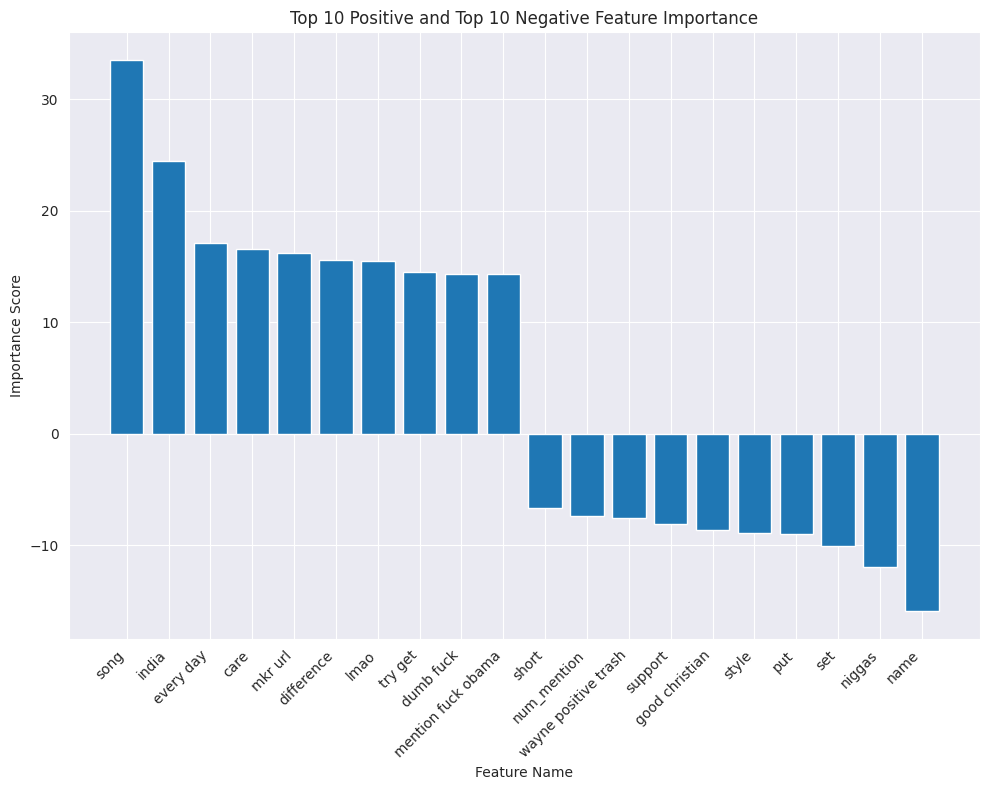

In [94]:
# Seleccionamos solo las 10 más positivas y las 10 más negativas
top_features = X_columns_sorted[:10] + X_columns_sorted[-10:]
top_importance = importance_sorted[:10] + importance_sorted[-10:]

# Mostrar el número de la característica, con su nombre, y su score de importancia
for i, (feature, importance) in enumerate(zip(top_features, top_importance)):
    print('Feature: %0d, Name: %s, Score: %.5f' % (i, feature, importance))

# Crear el plot
plt.figure(figsize=(10, 8))  # Ajusta el tamaño del gráfico según necesites
plt.bar(top_features, top_importance)  # Usar nombres de características ordenadas en el eje x

# Mejorar el gráfico
plt.xticks(rotation=45, ha="right")  # Rota los nombres en el eje x para mejor lectura
plt.xlabel('Feature Name')
plt.ylabel('Importance Score')
plt.title('Top 10 Positive and Top 10 Negative Feature Importance')
plt.tight_layout()  # Ajusta automáticamente los parámetros del subplot para que el subplot(s) encaje en el área de la figura.

plt.show()

Dentro de los terminos con una importancia negativa de lo mas importante, vemos palabras como "muslims", "go home" o "wife". De las palabras mas importante con impacto positivo sale la palabra "somebody" como numero 1.

Hemos terminado con el ejercicio 1.

In [95]:
import nbformat

def clean_notebook_metadata(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as f:
        nb = nbformat.read(f, as_version=4)

    # Eliminar metadata.widgets si existe
    if 'widgets' in nb['metadata']:
        del nb['metadata']['widgets']

    # Guardar el notebook limpio
    with open(output_file, 'w', encoding='utf-8') as f:
        nbformat.write(nb, f)

# Ejemplo de uso (reemplaza 'mi_notebook.ipynb' con tu archivo)
clean_notebook_metadata('Quispe_Lopez_Lilia_Ejercicio1.ipynb', 'Quispe_Lopez_Lilia_Ejercicio1_clean.ipynb')

FileNotFoundError: [Errno 2] No such file or directory: 'Quispe_Lopez_Lilia_Ejercicio1.ipynb'